In [1]:
import os
import shutil
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score


from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import datetime


In [2]:
import os
import cv2
import numpy as np

# Ruta de las carpetas
original_images_folder = "A. Segmentation/1. Original Images/a. Training Set"
soft_exudates_masks_folder = "A. Segmentation/2. All Segmentation Groundtruths/a. Training Set/4. Soft Exudates"

# Obtener todas las máscaras de Soft Exudates
mask_files = sorted(os.listdir(soft_exudates_masks_folder))

# Listas para almacenar las imágenes originales y las máscaras correspondientes
extracted_images = []
extracted_masks = []

# Procesar cada máscara
for mask_file in mask_files:
    if mask_file.endswith(".tif"):  # Asegurarse de que solo se procesen archivos .tif
        # Extraer el índice del nombre de la máscara
        index = mask_file.split("_")[1]  # Tomar la parte numérica después de "IDRiD_"
        
        
        # Construir el nombre del archivo de imagen original correspondiente
        original_image_filename = f"IDRiD_{index}.jpg"
        original_image_path = os.path.join(original_images_folder, original_image_filename)
        
      
        
        if os.path.exists(original_image_path):
            # Cargar la imagen original y la máscara
            image = cv2.imread(original_image_path)
            mask = cv2.imread(os.path.join(soft_exudates_masks_folder, mask_file), cv2.IMREAD_GRAYSCALE)

            # Redimensionar la imagen y la máscara a 256x256
            image_resized = cv2.resize(image, (256, 256))
            mask_resized = cv2.resize(mask, (256, 256))

            # Normalizar la imagen y la máscara
            image_normalized = image_resized.astype('float32') / 255.0  # Normalizar entre 0 y 1
            mask_normalized = mask_resized.astype('float32') / 76.0  # Normalizar entre 0 y 1
            mask_normalized = np.expand_dims(mask_normalized, axis=-1)  # Añadir el canal adicional

            # Añadir las imágenes y máscaras normalizadas a las listas
            extracted_images.append(image_normalized)
            extracted_masks.append(mask_normalized)
        else:
            print(f"Imagen no encontrada: {original_image_path}")

# Convertir las listas a arrays de NumPy si es necesario
extracted_images = np.array(extracted_images)
extracted_masks = np.array(extracted_masks)

# Imprimir las formas de las listas para verificar
print(f"Forma de las imágenes extraídas y normalizadas: {extracted_images.shape}")
print(f"Forma de las máscaras extraídas y normalizadas: {extracted_masks.shape}")


Forma de las imágenes extraídas y normalizadas: (26, 256, 256, 3)
Forma de las máscaras extraídas y normalizadas: (26, 256, 256, 1)


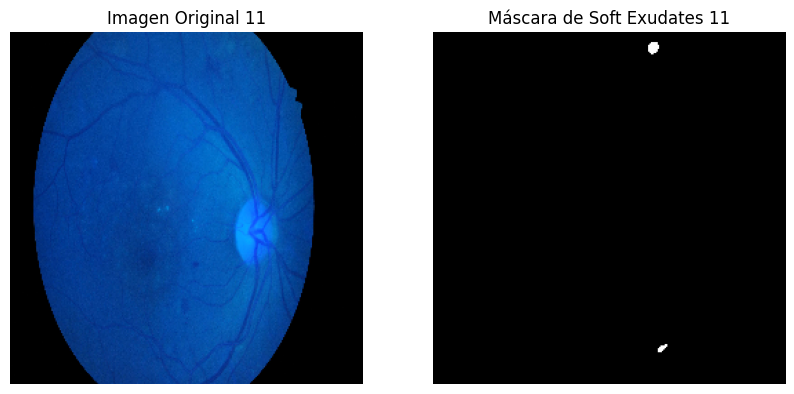

In [3]:
import matplotlib.pyplot as plt

# Supongamos que tienes la lista de imágenes y máscaras procesadas
# Aquí seleccionamos una imagen específica (por ejemplo, la primera imagen en la lista)

index = 10  # Cambia este índice para seleccionar la imagen que deseas visualizar

# Selecciona la imagen y su máscara correspondiente
image_to_show = extracted_images[index]
mask_to_show = extracted_masks[index]

# Eliminar el canal extra de la máscara
mask_to_show = mask_to_show.squeeze(axis=-1)  # Eliminar el canal extra

# Crear una figura con 1 fila y 2 columnas para mostrar la imagen y la máscara
plt.figure(figsize=(10, 5))

# Mostrar la imagen
plt.subplot(1, 2, 1)  # Fila 1, Columna 1
plt.imshow(image_to_show)
plt.title(f"Imagen Original {index + 1}")
plt.axis('off')  # No mostrar los ejes

# Mostrar la máscara
plt.subplot(1, 2, 2)  # Fila 1, Columna 2
plt.imshow(mask_to_show, cmap='gray')  # Mostrar en escala de grises
plt.title(f"Máscara de Soft Exudates {index + 1}")
plt.axis('off')  # No mostrar los ejes

# Mostrar la figura
plt.show()


In [25]:


# Definir la métrica Dice Score
def dice_score(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

# Definir la arquitectura U-Net
def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    
    # Contracción (Encoder)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    # Capa intermedia (Bottleneck)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    
    # Expansión (Decoder)
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = Model(inputs, outputs)
    return model

# Crear modelo
model = unet_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy', dice_score])

# Definir callbacks
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_unet_modelSE.h5", save_best_only=True, monitor='val_loss', mode='min')
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [early_stopping, checkpoint, tensorboard]


In [26]:
x_train=extracted_images
y_train=extracted_masks
history = model.fit(x_train, y_train, validation_split=0.2, epochs=50, batch_size=4, callbacks=callbacks)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.8719 - dice_score: 0.0071 - loss: 0.6799 

5/5 ━━━━━━━━━━━━━━━━━━━━ 204s 41s/step - accuracy: 0.8833 - dice_score: 0.0073 - loss: 0.6785 - val_accuracy: 0.9971 - val_dice_score: 0.0049 - val_loss: 0.6318
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.9957 - dice_score: 0.0077 - loss: 0.5554 

5/5 ━━━━━━━━━━━━━━━━━━━━ 229s 49s/step - accuracy: 0.9957 - dice_score: 0.0076 - loss: 0.5352 - val_accuracy: 0.9971 - val_dice_score: 2.1518e-04 - val_loss: 0.0661
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 226s 48s/step - accuracy: 0.9953 - dice_score: 3.3150e-04 - loss: 0.1323 - val_accuracy: 0.9971 - val_dice_score: 7.0371e-06 - val_loss: 0.0983
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 233s 49s/step - accuracy: 0.9955 - dice_score: 5.1442e-04 - loss: 0.1102 - val_accuracy: 0.9971 - val_dice_score: 0.0012 - val_loss: 0.0858
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.9959 - dice_score: 0.0027 - loss: 0.0899 

5/5 ━━━━━━━━━━━━━━━━━━━━ 229s 49s/step - accuracy: 0.9958 - dice_score: 0.0026 - loss: 0.0886 - val_accuracy: 0.9971 - val_dice_score: 1.5403e-04 - val_loss: 0.0502
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 0.9962 - dice_score: 8.2515e-04 - loss: 0.0625 

5/5 ━━━━━━━━━━━━━━━━━━━━ 239s 52s/step - accuracy: 0.9961 - dice_score: 8.1091e-04 - loss: 0.0643 - val_accuracy: 0.9971 - val_dice_score: 2.9636e-04 - val_loss: 0.0410
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 0.9948 - dice_score: 0.0026 - loss: 0.0579 

5/5 ━━━━━━━━━━━━━━━━━━━━ 223s 48s/step - accuracy: 0.9949 - dice_score: 0.0025 - loss: 0.0574 - val_accuracy: 0.9971 - val_dice_score: 0.0012 - val_loss: 0.0363
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 0.9953 - dice_score: 0.0023 - loss: 0.0462 

5/5 ━━━━━━━━━━━━━━━━━━━━ 203s 43s/step - accuracy: 0.9954 - dice_score: 0.0023 - loss: 0.0460 - val_accuracy: 0.9971 - val_dice_score: 6.0865e-04 - val_loss: 0.0277
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 0.9947 - dice_score: 0.0056 - loss: 0.0439 

5/5 ━━━━━━━━━━━━━━━━━━━━ 216s 46s/step - accuracy: 0.9948 - dice_score: 0.0055 - loss: 0.0433 - val_accuracy: 0.9971 - val_dice_score: 0.0029 - val_loss: 0.0254
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.9957 - dice_score: 0.0056 - loss: 0.0345 

5/5 ━━━━━━━━━━━━━━━━━━━━ 209s 45s/step - accuracy: 0.9957 - dice_score: 0.0055 - loss: 0.0346 - val_accuracy: 0.9971 - val_dice_score: 0.0016 - val_loss: 0.0226
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 235s 51s/step - accuracy: 0.9959 - dice_score: 0.0057 - loss: 0.0305 - val_accuracy: 0.9971 - val_dice_score: 0.0037 - val_loss: 0.0241
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - accuracy: 0.9959 - dice_score: 0.0062 - loss: 0.0295 

5/5 ━━━━━━━━━━━━━━━━━━━━ 196s 42s/step - accuracy: 0.9959 - dice_score: 0.0061 - loss: 0.0296 - val_accuracy: 0.9971 - val_dice_score: 0.0024 - val_loss: 0.0201
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - accuracy: 0.9957 - dice_score: 0.0041 - loss: 0.0286 

5/5 ━━━━━━━━━━━━━━━━━━━━ 202s 44s/step - accuracy: 0.9957 - dice_score: 0.0042 - loss: 0.0286 - val_accuracy: 0.9971 - val_dice_score: 0.0036 - val_loss: 0.0200
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.9953 - dice_score: 0.0056 - loss: 0.0294 

5/5 ━━━━━━━━━━━━━━━━━━━━ 203s 44s/step - accuracy: 0.9954 - dice_score: 0.0055 - loss: 0.0291 - val_accuracy: 0.9971 - val_dice_score: 0.0037 - val_loss: 0.0197
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 0.9956 - dice_score: 0.0046 - loss: 0.0282 

5/5 ━━━━━━━━━━━━━━━━━━━━ 242s 52s/step - accuracy: 0.9956 - dice_score: 0.0046 - loss: 0.0282 - val_accuracy: 0.9971 - val_dice_score: 0.0036 - val_loss: 0.0192
Epoch 16/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 228s 49s/step - accuracy: 0.9957 - dice_score: 0.0055 - loss: 0.0272 - val_accuracy: 0.9971 - val_dice_score: 0.0037 - val_loss: 0.0193
Epoch 17/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 227s 48s/step - accuracy: 0.9963 - dice_score: 0.0036 - loss: 0.0249 - val_accuracy: 0.9971 - val_dice_score: 0.0046 - val_loss: 0.0208
Epoch 18/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.9958 - dice_score: 0.0069 - loss: 0.0273 

5/5 ━━━━━━━━━━━━━━━━━━━━ 226s 49s/step - accuracy: 0.9958 - dice_score: 0.0069 - loss: 0.0274 - val_accuracy: 0.9971 - val_dice_score: 0.0033 - val_loss: 0.0191
Epoch 19/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 214s 45s/step - accuracy: 0.9960 - dice_score: 0.0039 - loss: 0.0267 - val_accuracy: 0.9971 - val_dice_score: 0.0045 - val_loss: 0.0203
Epoch 20/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 0.9956 - dice_score: 0.0064 - loss: 0.0277 

5/5 ━━━━━━━━━━━━━━━━━━━━ 233s 50s/step - accuracy: 0.9956 - dice_score: 0.0064 - loss: 0.0278 - val_accuracy: 0.9971 - val_dice_score: 0.0033 - val_loss: 0.0189
Epoch 21/50


KeyboardInterrupt: 

In [4]:



# Rutas de los datos
path_masks = r"A. Segmentation/2. All Segmentation Groundtruths/b. Testing Set/4. Soft Exudates"
path_images = r"A. Segmentation/1. Original Images/b. Testing Set"

# Obtener lista de archivos de máscaras
mask_files = sorted(glob(os.path.join(path_masks, "*.tif")))

x_test = []
y_test = []

for mask_path in mask_files:
    # Extraer el índice de la imagen
    filename = os.path.basename(mask_path)
    index = filename.split("_")[1]  # Extrae el número IDRiD_XX_SE.tif → XX

    # Construir el nombre de la imagen original correspondiente
    image_path = os.path.join(path_images, f"IDRiD_{index}.jpg")

    if os.path.exists(image_path):
        # Cargar la imagen y la máscara
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Redimensionar a 256x256
        image = cv2.resize(image, (256, 256))
        mask = cv2.resize(mask, (256, 256))

        # Normalizar las imágenes
        image = image / 255.0  # Normalizar imagen RGB
        mask = mask / 76.0  # Normalizar la máscara

        # Agregar a los arrays de test
        x_test.append(image)
        y_test.append(mask)
    else:
        print(f"⚠️ Imagen no encontrada para {filename}")

# Convertir a arrays de NumPy
x_test = np.array(x_test)
y_test = np.array(y_test)

# Revisar dimensiones
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")


x_test shape: (14, 256, 256, 3), y_test shape: (14, 256, 256)


In [6]:
x_test = np.array(x_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)


In [10]:
# Definir la métrica Dice Score
def dice_score(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

# Cargar el modelo con la métrica personalizada
model = load_model("best_unet_modelSE.h5", custom_objects={"dice_score": dice_score})

# Evaluar el modelo con batch_size=1
results = model.evaluate(x_test, y_test, batch_size=1)

# Mostrar los resultados
print(f"Loss: {results[0]:.4f}")
print(f"Accuracy: {results[1]:.4f}")
print(f"Dice Score: {results[2]:.4f}")  # Si hay más métricas, ajusta el índice





14/14 ━━━━━━━━━━━━━━━━━━━━ 65s 4s/step - accuracy: 0.9957 - dice_score: 0.0035 - loss: 0.0276
Loss: 0.0227
Accuracy: 0.9965
Dice Score: 0.0039
